In [6]:
import numpy as np
import pandas as pd
df = pd.read_csv("SampleSizeShiny/data/pearson_pval_0.05_num_edges_vs_num_samples.txt", sep=",")
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb

import statsmodels.api as sm
from itertools import cycle
cycol = cycle('bgrcmk')


def sol(N,a,b):
    y=np.exp((np.exp(b)*N**(1+a))/(a+1))
    y=y/max(y)
    return y


def grad(df):
    dataset=set(df.dataset) # Different datasets
    sample_number=set(df.rep) # Different numbrer of samples per size (repetitions)
    plt.figure()
    for data in dataset:

        n_samples_l=[]
        sign_edges_l=[]
 
        # Get size and significant edges for each repetition
        for sample in sample_number:
            data_bool=df.dataset==data
            sample_bool=df.rep==sample
            current=df[data_bool&sample_bool]
            sign_edges_l.append(current.num_edges)
            n_samples_l.append(current['size'])
           
        # Calculate the gradient: the ratio between the difference of consecutive samples and the difference of consecutive significant edges
        # Before calculating the gradient, we calculate the mean between different repetitions
        grad=1/(np.diff(np.mean(n_samples_l,axis=0))/np.diff(np.mean(sign_edges_l,axis=0)))
        # The gradient is divided by the significant edges to obtain the fraction gradient
        frac_grad=grad/np.mean(sign_edges_l,axis=0)[1:]
        # Check which factions are negative so that we ignore them. 
        # Why? Because some consecutive differences might give negative values! 
        # This does not make sense in theory, and as the number of situations like this is very small, we ignore it.
        boo=frac_grad>0 
        normx=np.mean(n_samples_l,axis=0)
        # Calculate polynomial fit between logarithm of sample size and logarithm of fraction gradient
        # we obtain a list with the coefficient estimates of the polynomial
        para=np.polyfit( np.log(normx[1:][boo]),np.log(frac_grad[boo]), 1, rcond=None, full=False, w=None, cov=False)
        # Keep the coefficient estimates in a polynomial form
        p = np.poly1d(para)
        # Make prediction: y = exp(pol(ln(x)))
        y=np.exp(p(np.log(normx[1:][boo])))
        plt.figure()
        normx=np.mean(n_samples_l,axis=0)
        normy=np.mean(sign_edges_l,axis=0)
        plt.plot(normx,normy/np.max(normy),'o',label=data,c=next(cycol))
        a,b=para
        y=sol(normx,a,b)
        plt.plot(normx,y,'-',c=next(cycol),label='Model prediction')
        plt.legend()


<Figure size 432x288 with 0 Axes>

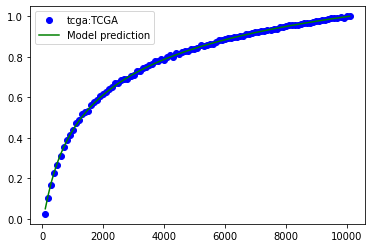

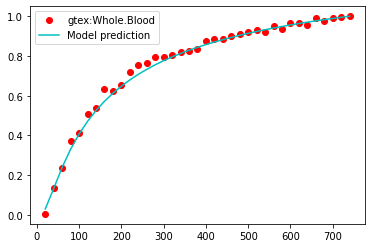

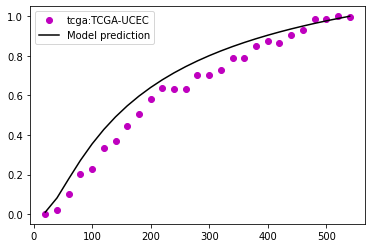

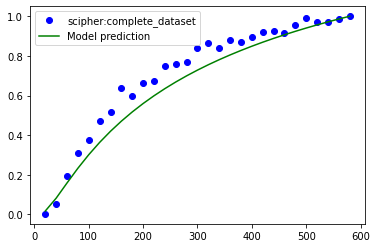

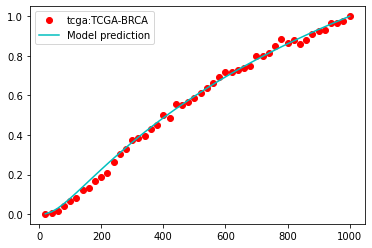

In [5]:
grad(df)

In [8]:
    dataset=set(df.dataset)
    sample_number=set(df.rep)      


In [13]:
sample_number=set(df.rep)

In [14]:
sample_number

{1, 2, 3, 4, 5}

In [46]:
frac_grad=grad/np.mean(sign_edges_l,axis=0)[1:]
boo=frac_grad>0


In [48]:
boo

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False])

In [49]:
        normx=np.mean(n_samples_l,axis=0)


In [50]:
normx

array([  100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
         900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,
        1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,
        2500.,  2600.,  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,
        3300.,  3400.,  3500.,  3600.,  3700.,  3800.,  3900.,  4000.,
        4100.,  4200.,  4300.,  4400.,  4500.,  4600.,  4700.,  4800.,
        4900.,  5000.,  5100.,  5200.,  5300.,  5400.,  5500.,  5600.,
        5700.,  5800.,  5900.,  6000.,  6100.,  6200.,  6300.,  6400.,
        6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,  7200.,
        7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
        8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,
        8900.,  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,
        9700.,  9800.,  9900., 10000., 10100.])

In [51]:
        para=np.polyfit( np.log(normx[1:][boo]),np.log(frac_grad[boo]), 1, rcond=None, full=False, w=None, cov=False)


In [53]:
        p = np.poly1d(para)
        y=np.exp(p(np.log(normx[1:][boo])))


In [59]:
para


array([-1.41889453,  2.31171449])

In [60]:
p

poly1d([-1.41889453,  2.31171449])

In [55]:
y

array([5.48335014e-03, 3.08454461e-03, 2.05076627e-03, 1.49420807e-03,
       1.15361592e-03, 9.26980948e-04, 7.66984085e-04, 6.48942650e-04,
       5.58831998e-04, 4.88145636e-04, 4.31450949e-04, 3.85130281e-04,
       3.46689745e-04, 3.14359321e-04, 2.86851113e-04, 2.63207677e-04,
       2.42703760e-04, 2.24780849e-04, 2.09002486e-04, 1.95023107e-04,
       1.82565873e-04, 1.71406631e-04, 1.61362129e-04, 1.44038256e-04,
       1.36527954e-04, 1.29661542e-04, 1.23363669e-04, 1.17570003e-04,
       1.12225319e-04, 1.07281967e-04, 1.02698636e-04, 9.84393503e-05,
       9.44726494e-05, 9.07709104e-05, 8.73097910e-05, 8.10257256e-05,
       7.54754315e-05, 7.29384043e-05, 6.82794138e-05, 6.41058710e-05,
       6.21792233e-05, 6.03492395e-05, 5.86092042e-05, 5.53750096e-05,
       5.38701320e-05, 5.10612883e-05, 4.97490391e-05, 4.72905723e-05,
       4.61378617e-05, 4.39710377e-05, 4.29517695e-05, 4.10299827e-05,
       3.92502975e-05, 3.84091645e-05, 3.75983035e-05, 3.68161970e-05,
      